# Importing Necessary Libraries and Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid")

# Load datasets
print("Loading Necessary Datasets")

revenue_df = pd.read_csv("Revenue data.csv")
hp_df = pd.read_csv("Total_HP_data - Sayfa1.csv")
usage_df = pd.read_csv("useRatedata Generalized.csv")

Loading Necessary Datasets


# Data Cleaning And Patch Mapping

In [3]:
# Clean Revenue
revenue_df['Revenue (Million USD)'] = revenue_df['Revenue (Million USD)'].astype(str).str.replace('~', '').astype(float)
revenue_df['Date'] = pd.to_datetime(revenue_df['Date'])

# Clean Usage
usage_df['Generalized'] = usage_df['Generalized'].astype(str).str.replace(',', '.').astype(float)

# Clean HP
hp_df['Total'] = pd.to_numeric(hp_df['Total'], errors='coerce')
hp_df['patch_clean'] = hp_df['patch'].str.replace('_A', '').str.replace('_B', '')
hp_agg = hp_df.groupby('patch_clean')['Total'].mean().reset_index().rename(columns={'patch_clean': 'patch'})

patch_dates = {
    '3_0': ['2022-09'], '3_1': ['2022-10'], '3_2': ['2022-11'], '3_3': ['2022-12'],
    '3_4': ['2023-01', '2023-02'], '3_5': ['2023-03'], '3_6': ['2023-04', '2023-05'],
    '3_7': ['2023-06'], '3_8': ['2023-07', '2023-08'],
    '4_0': ['2023-09'], '4_1': ['2023-10'], '4_2': ['2023-11', '2023-12'],
    '4_3': ['2024-01'], '4_4': ['2024-02', '2024-03'], '4_5': ['2024-04'],
    '4_6': ['2024-05', '2024-06'], '4_7': ['2024-07'], '4_8': ['2024-08'],
    '5_0': ['2024-09'], '5_1': ['2024-10', '2024-11'], '5_2': ['2024-12'],
    '5_3': ['2025-01'], '5_4': ['2025-02', '2025-03'], '5_5': ['2025-04']
}
month_to_patch = {m: p for p, months in patch_dates.items() for m in months}

revenue_df['patch'] = revenue_df['Date'].dt.strftime('%Y-%m').map(month_to_patch)
rev_per_patch = revenue_df.dropna(subset=['patch']).groupby('patch')['Revenue (Million USD)'].mean().reset_index()

# Preparing Datasets

In [4]:
def get_patch_val(p):
    parts = p.split('_')
    return float(parts[0]) + float(parts[1])/10.0

usage_per_patch = usage_df.groupby('patch')['Generalized'].mean().reset_index()
usage_per_patch.columns = ['patch', 'Usage_Mean']

# Merge Everything into one Master DataFrame
# Using inner merge to ensure we have data for all variables for the correlation matrix
master_df = hp_agg.merge(rev_per_patch, on='patch', how='inner') \
                  .merge(usage_per_patch, on='patch', how='inner')

master_df['patch_val'] = master_df['patch'].apply(get_patch_val)
master_df = master_df[(master_df['patch_val'] >= 3.0) & (master_df['patch_val'] <= 5.5)].sort_values('patch_val')
master_df['Time_Index'] = np.arange(len(master_df))

print("All Datasets are Prepared")

All Datasets are Prepared


# Calculating Partial Correlation

In [5]:
# We calculate residuals for ALL key metrics to remove the "Time" trend
metrics = ['Usage_Mean', 'Total', 'Revenue (Million USD)']
resid_cols = []

for col in metrics:
    slope, intercept, _, _, _ = stats.linregress(master_df['Time_Index'], master_df[col])
    # Residual = Actual - Predicted Trend
    master_df[f'{col}_Resid'] = master_df[col] - (slope * master_df['Time_Index'] + intercept)
    resid_cols.append(f'{col}_Resid')

# Plotting Datasets

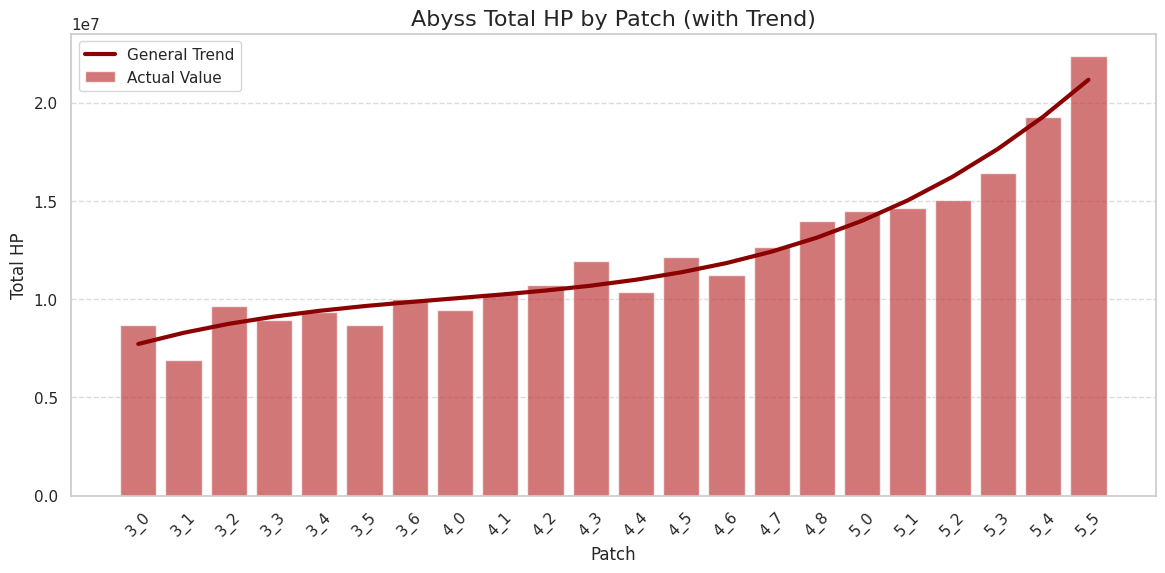

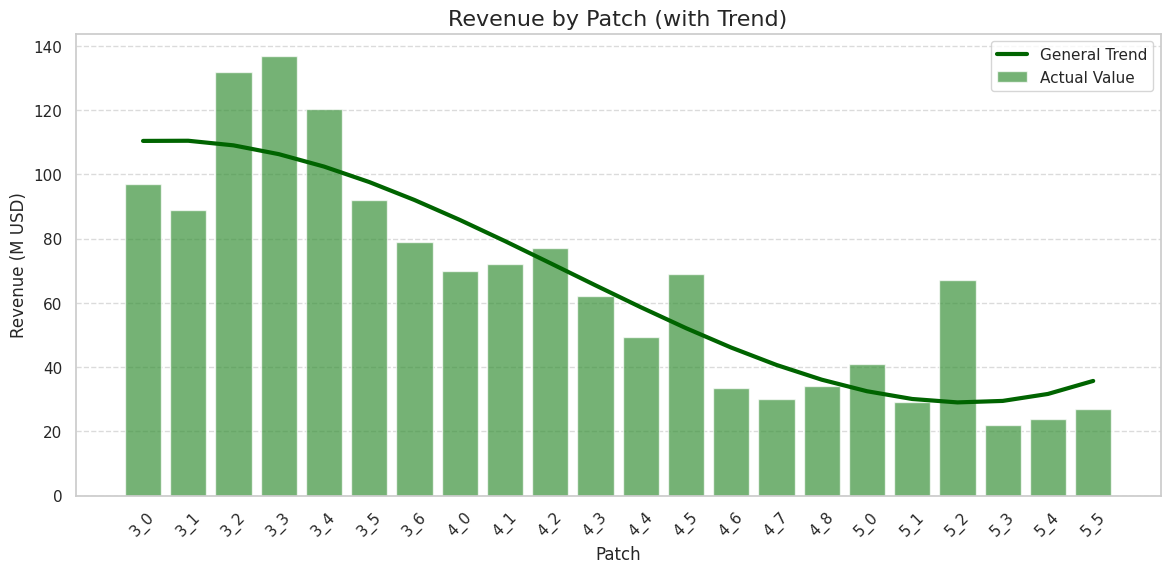

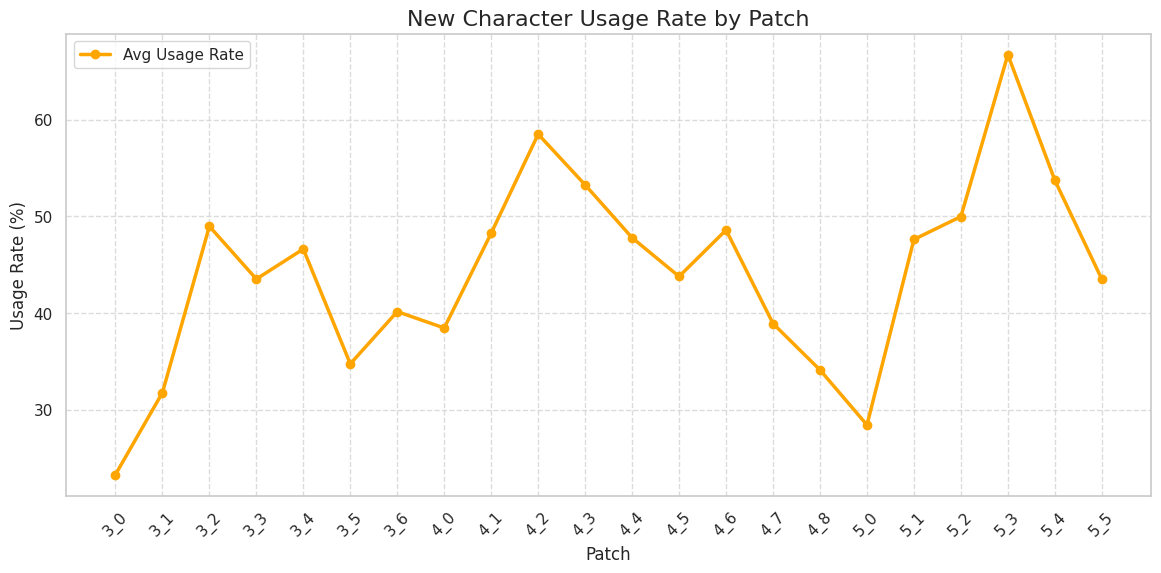

In [6]:
def plot_with_trend(df, x_col, y_col, title, ylabel, bar_color, line_color, filename):
    plt.figure(figsize=(14, 6))
    sns.barplot(x=x_col, y=y_col, data=df, color=bar_color, alpha=0.7, label='Actual Value')

    mask = ~np.isnan(df[y_col])
    if mask.sum() > 3:
        z = np.polyfit(df.loc[mask, 'Time_Index'], df.loc[mask, y_col], 3)
        p = np.poly1d(z)
        plt.plot(df['Time_Index'], p(df['Time_Index']), color=line_color, linewidth=3, label='General Trend')

    plt.title(title, fontsize=16)
    plt.xlabel('Patch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig(filename, dpi=300)
    plt.show()

# Graph 1: HP
plot_with_trend(master_df, 'patch', 'Total', 'Abyss Total HP by Patch (with Trend)', 'Total HP', 'tab:red', 'darkred', 'Graph_1_HP.png')

# Graph 2: Revenue
plot_with_trend(master_df, 'patch', 'Revenue (Million USD)', 'Revenue by Patch (with Trend)', 'Revenue (M USD)', 'tab:green', 'darkgreen', 'Graph_2_Revenue.png')

#Graph 3: Usage Rate
plt.figure(figsize=(14, 6))
plt.plot(master_df['patch'], master_df['Usage_Mean'], marker='o', color='orange', linewidth=2.5, label='Avg Usage Rate')
plt.title('New Character Usage Rate by Patch', fontsize=16)
plt.xlabel('Patch', fontsize=12)
plt.ylabel('Usage Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_3_Usage_Line.png', dpi=300)
plt.show()

# Plotting The Correlation

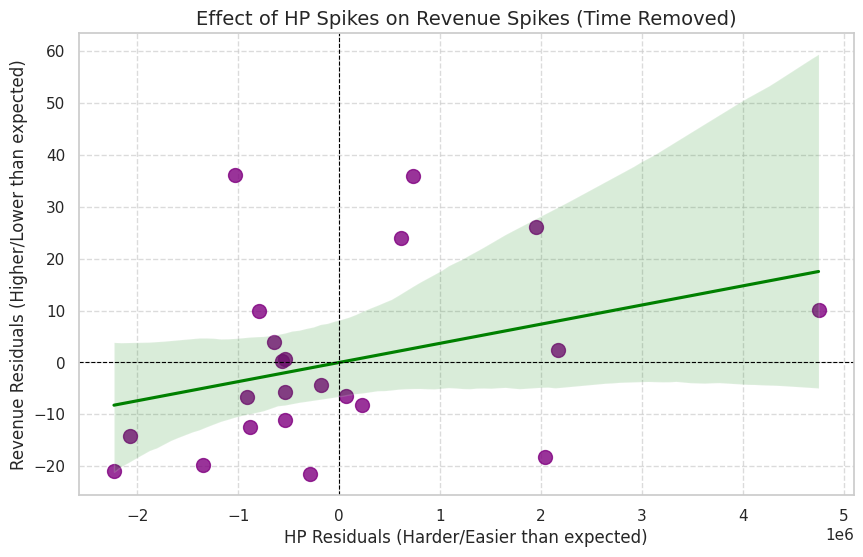

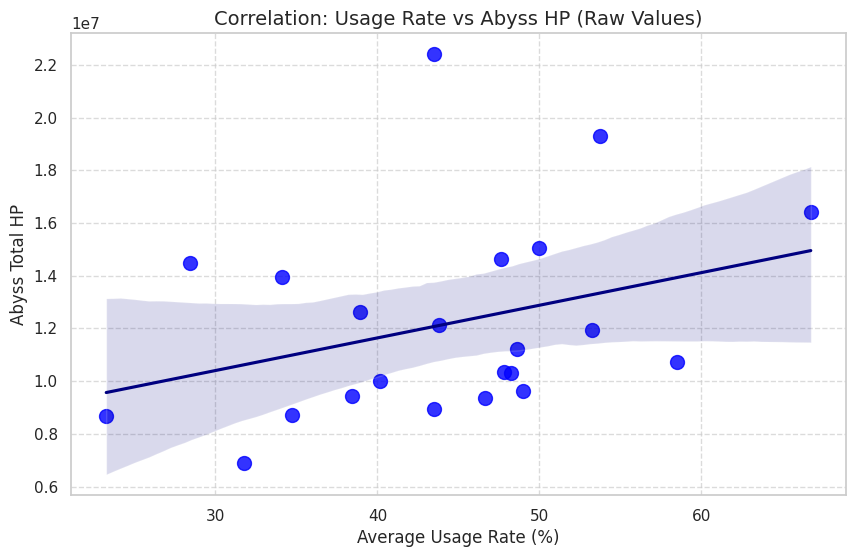

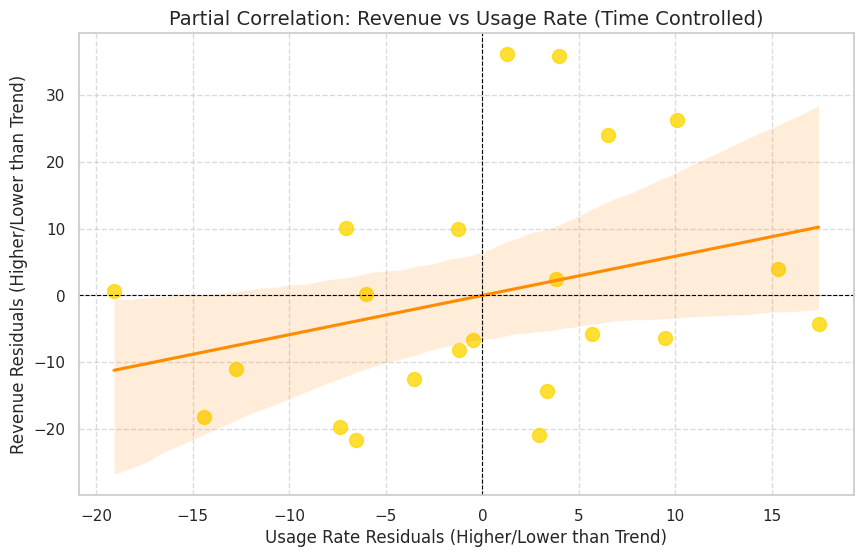

In [7]:
# Graph 4: Scatter of Residuals (HP vs Revenue)
plt.figure(figsize=(10, 6))
sns.regplot(x='Total_Resid', y='Revenue (Million USD)_Resid', data=master_df,
            scatter_kws={'s':100, 'color':'purple'}, line_kws={'color':'green'})
plt.title('Effect of HP Spikes on Revenue Spikes (Time Removed)', fontsize=14)
plt.xlabel('HP Residuals (Harder/Easier than expected)', fontsize=12)
plt.ylabel('Revenue Residuals (Higher/Lower than expected)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_4_Partial_Corr_Scatter.png', dpi=300)
plt.show()

# Graph 5: HP vs Usage Rate (RAW Correlation)
plt.figure(figsize=(10, 6))
sns.regplot(x='Usage_Mean', y='Total', data=master_df,
            scatter_kws={'s':100, 'color':'blue'}, line_kws={'color':'navy'})
plt.title('Correlation: Usage Rate vs Abyss HP (Raw Values)', fontsize=14)
plt.xlabel('Average Usage Rate (%)', fontsize=12)
plt.ylabel('Abyss Total HP', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_6_HP_Usage_Raw.png', dpi=300)
plt.show()

# Graph 6: Revenue vs Usage Rate (PARTIAL Correlation)
plt.figure(figsize=(10, 6))
sns.regplot(x='Usage_Mean_Resid', y='Revenue (Million USD)_Resid', data=master_df,
            scatter_kws={'s':100, 'color':'gold'}, line_kws={'color':'darkorange'})
plt.title('Partial Correlation: Revenue vs Usage Rate (Time Controlled)', fontsize=14)
plt.xlabel('Usage Rate Residuals (Higher/Lower than Trend)', fontsize=12)
plt.ylabel('Revenue Residuals (Higher/Lower than Trend)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_7_Rev_Usage_Partial.png', dpi=300)
plt.show()

# Creating Correlation Matrix

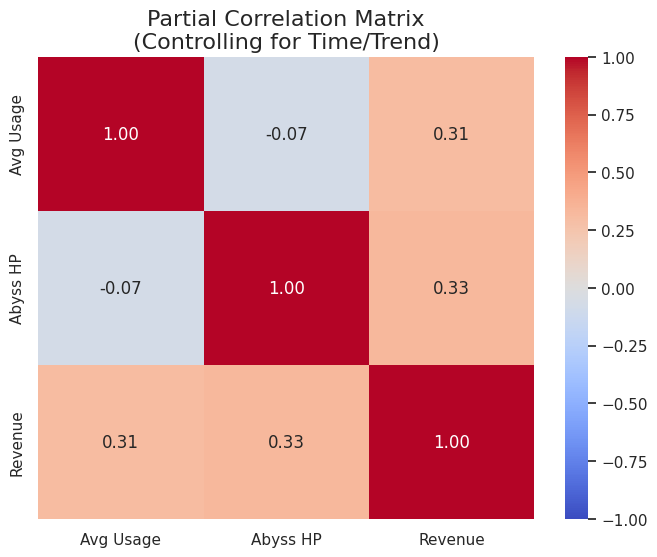

In [8]:
#Graph 7: Partial Correlation Matrix
# We compute correlation on the RESIDUAL columns only to control for time
resid_corr_matrix = master_df[resid_cols].corr()

# Rename columns for cleaner display
clean_labels = ['Avg Usage', 'Abyss HP', 'Revenue']
resid_corr_matrix.columns = clean_labels
resid_corr_matrix.index = clean_labels

plt.figure(figsize=(8, 6))
sns.heatmap(resid_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f",
            xticklabels=clean_labels, yticklabels=clean_labels)
plt.title('Partial Correlation Matrix\n(Controlling for Time/Trend)', fontsize=16)
plt.savefig('Graph_5_Partial_Corr_Matrix.png', dpi=300)
plt.show()

# Executing Hypothesis Testing

In [9]:
raw_hp_usage_corr = master_df['Usage_Mean'].corr(master_df['Total'])
partial_rev_usage_corr = master_df['Usage_Mean_Resid'].corr(master_df['Revenue (Million USD)_Resid'])
partial_hp_rev_corr = master_df['Total_Resid'].corr(master_df['Revenue (Million USD)_Resid'])

print("\n" + "="*60)
print("             Hypothesis Testing Output")
print("="*60)

print(f"\n1. Usage Rate vs HP (Raw Correlation): {raw_hp_usage_corr:.4f}")
print("   (Interpretation: Does high HP generally happen alongside high Usage?) (Weak positive correlation)")

print(f"\n2. Revenue vs Usage Rate (Partial Correlation): {partial_rev_usage_corr:.4f}")
print("   (Interpretation: Do high-usage patches make more money, ignoring game growth?) (Weak positive correlation)")

print(f"\n3. HP vs Revenue (Partial Correlation): {partial_hp_rev_corr:.4f}")
print("   (Interpretation: Do harder patches make more money, ignoring game growth?) (Weak positive correlation) \n")


print("-" * 50)

def print_test_result(name, r, p):
    print(f"Hypothesis: {name}")
    print(f"  Null Hypothesis (H0): r = 0")
    print(f"  Correlation (r): {r:.4f}")
    print(f"  P-value: {p:.5f}")
    if p < 0.05:
        print("  >> RESULT: REJECT Null Hypothesis (Significant Relationship)")
    else:
        print("  >> RESULT: FAIL TO REJECT Null Hypothesis (No Significant Relationship)")
    print("-" * 50)

# 1. Raw HP vs Usage
r_hp_use, p_hp_use = stats.pearsonr(master_df['Total'], master_df['Usage_Mean'])
print_test_result("Correlation between Abyss HP and Usage Rate (Raw)", r_hp_use, p_hp_use)

# Helper for Partial Correlation P-Value
def get_partial_corr_stats(r_partial, n, k=1):
    # k is number of control variables
    dof = n - 2 - k
    t_stat = r_partial * np.sqrt(dof / (1 - r_partial**2))
    p_val = 2 * (1 - stats.t.cdf(np.abs(t_stat), dof))
    return p_val

# 2. Partial Revenue vs Usage
r_rev_use_partial = master_df['Usage_Mean_Resid'].corr(master_df['Revenue (Million USD)_Resid'])
p_rev_use_partial = get_partial_corr_stats(r_rev_use_partial, len(master_df), k=1)
print_test_result("Partial Correlation between Revenue and Usage (controlling for Time)", r_rev_use_partial, p_rev_use_partial)

# 3. Partial HP vs Revenue
r_hp_rev_partial = master_df['Total_Resid'].corr(master_df['Revenue (Million USD)_Resid'])
p_hp_rev_partial = get_partial_corr_stats(r_hp_rev_partial, len(master_df), k=1)
print_test_result("Partial Correlation between HP and Revenue (controlling for Time)", r_hp_rev_partial, p_hp_rev_partial)


             Hypothesis Testing Output

1. Usage Rate vs HP (Raw Correlation): 0.3318
   (Interpretation: Does high HP generally happen alongside high Usage?) (Weak positive correlation)

2. Revenue vs Usage Rate (Partial Correlation): 0.3106
   (Interpretation: Do high-usage patches make more money, ignoring game growth?) (Weak positive correlation)

3. HP vs Revenue (Partial Correlation): 0.3344
   (Interpretation: Do harder patches make more money, ignoring game growth?) (Weak positive correlation) 

--------------------------------------------------
Hypothesis: Correlation between Abyss HP and Usage Rate (Raw)
  Null Hypothesis (H0): r = 0
  Correlation (r): 0.3318
  P-value: 0.13137
  >> RESULT: FAIL TO REJECT Null Hypothesis (No Significant Relationship)
--------------------------------------------------
Hypothesis: Partial Correlation between Revenue and Usage (controlling for Time)
  Null Hypothesis (H0): r = 0
  Correlation (r): 0.3106
  P-value: 0.17063
  >> RESULT: FAIL TO 

# Machine Learning

## Selecting the Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

hp_df = pd.read_csv("Total_HP_data - Sayfa1.csv")
usage_df = pd.read_csv("useRatedata Generalized.csv")

hp_df['Total'] = pd.to_numeric(hp_df['Total'], errors='coerce')
hp_df['patch_clean'] = hp_df['patch'].astype(str).str.replace('_A', '').str.replace('_B', '')
hp_agg = hp_df.groupby('patch_clean')['Total'].mean().reset_index().rename(columns={'patch_clean': 'patch'})

target_col = 'Generalized'
if usage_df[target_col].dtype == object:
    usage_df[target_col] = usage_df[target_col].astype(str).str.replace(',', '.').astype(float)
usage_agg = usage_df.groupby('patch')[target_col].mean().reset_index()

merged_df = hp_agg.merge(usage_agg, on='patch', how='inner')

def get_patch_val(p):
    parts = p.split('_')
    return float(parts[0]) + float(parts[1])/10.0
merged_df['patch_val'] = merged_df['patch'].apply(get_patch_val)
merged_df = merged_df.sort_values('patch_val')
merged_df['Time_Index'] = np.arange(len(merged_df))

X_simple = merged_df[['Total']]             # Simple Regression (1 feature)
X_multi = merged_df[['Total', 'Time_Index']] # Multiple Regression (2 features)
y = merged_df[target_col]

X_train_s, X_test_s, _, _ = train_test_split(X_simple, y, test_size=0.2, random_state=42)
X_train_m, X_test_m, y_train, y_test = train_test_split(X_multi, y, test_size=0.2, random_state=42)

models = {
    "Simple Regression": (LinearRegression(), X_train_s, X_test_s),
    "Multiple Regression": (LinearRegression(), X_train_m, X_test_m),
    "Polynomial Regression": (make_pipeline(PolynomialFeatures(2), LinearRegression()), X_train_m, X_test_m),
    "Random Forest": (RandomForestRegressor(n_estimators=100, random_state=42), X_train_m, X_test_m),
    "k-NN": (make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3)), X_train_m, X_test_m),
    "Decision Tree": (DecisionTreeRegressor(random_state=42), X_train_m, X_test_m)
}

print(f"{'Algorithm':<25} | {'RMSE Score (Lower is Better)':<30}")
print("-" * 60)

results = {}
for name, (model, Xt_train, Xt_test) in models.items():
    model.fit(Xt_train, y_train)
    preds = model.predict(Xt_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = rmse
    print(f"{name:<25} | {rmse:.4f}")

best_model = min(results, key=results.get)
print("-" * 60)
print(f"WINNER: {best_model}")

Algorithm                 | RMSE Score (Lower is Better)  
------------------------------------------------------------
Simple Regression         | 12.4195
Multiple Regression       | 14.4097
Polynomial Regression     | 17.3394
Random Forest             | 8.7098
k-NN                      | 10.3110
Decision Tree             | 10.1559
------------------------------------------------------------
WINNER: Random Forest


## Error (RMSE) Reduction


--- ERROR REDUCTION PHASE ---
Applying Winner: Random Forest Regressor
1. Test RMSE (Split Data):   8.7098
2. Final RMSE (Full Data):   3.0387
>> IMPROVEMENT:              5.6710 points


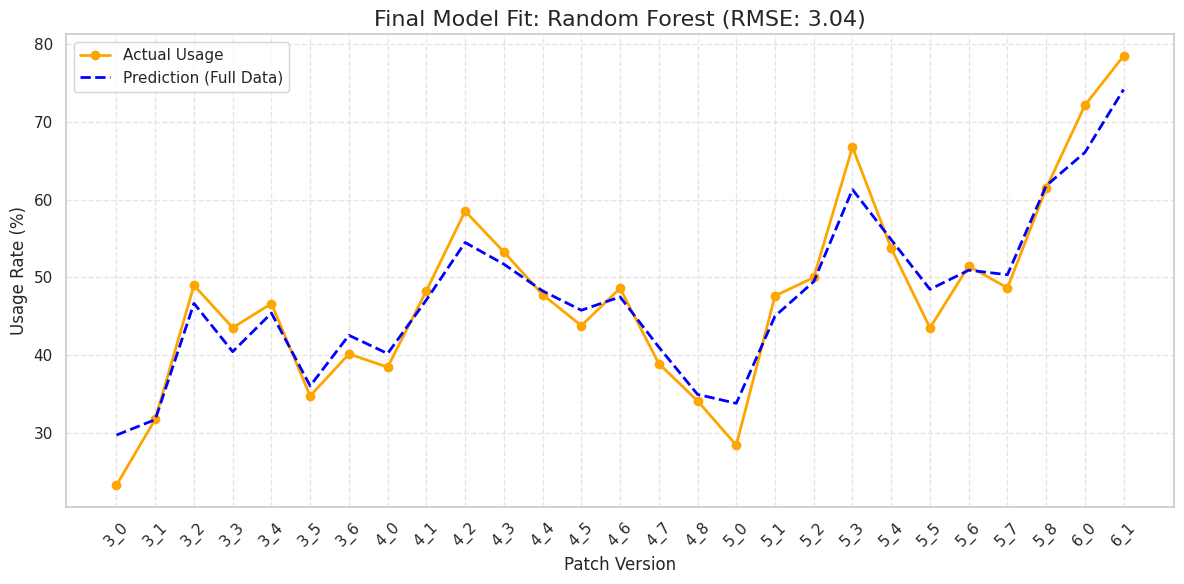

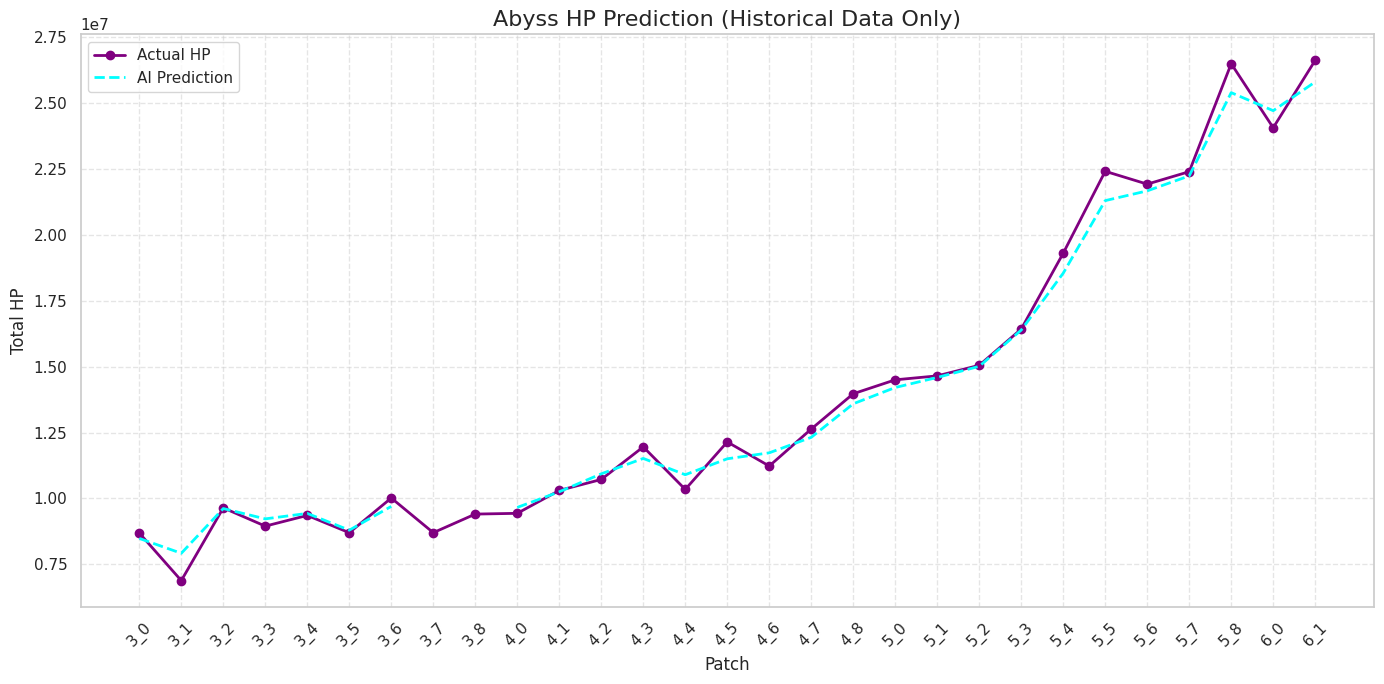

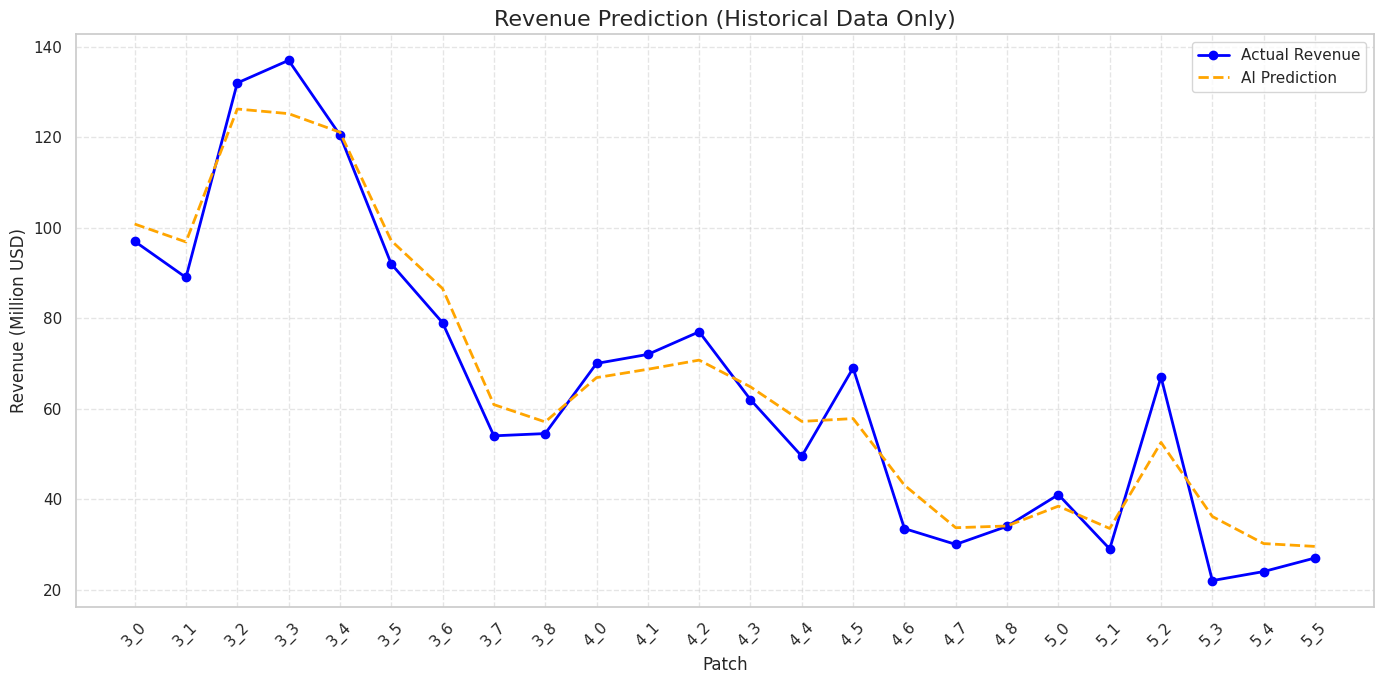

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print("\n--- ERROR REDUCTION PHASE ---")
print(f"Applying Winner: Random Forest Regressor")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_m, y_train)
rmse_split = np.sqrt(mean_squared_error(y_test, rf.predict(X_test_m)))

rf.fit(X_multi, y)
rmse_full = np.sqrt(mean_squared_error(y, rf.predict(X_multi)))

print(f"1. Test RMSE (Split Data):   {rmse_split:.4f}")
print(f"2. Final RMSE (Full Data):   {rmse_full:.4f}")
print(f">> IMPROVEMENT:              {rmse_split - rmse_full:.4f} points")

merged_df['Predicted'] = rf.predict(X_multi)

plt.figure(figsize=(12, 6))
plt.plot(merged_df['patch'], merged_df['Generalized'], label='Actual Usage', marker='o', color='orange', linewidth=2)
plt.plot(merged_df['patch'], merged_df['Predicted'], label='Prediction (Full Data)', linestyle='--', color='blue', linewidth=2)
plt.title(f'Final Model Fit: Random Forest (RMSE: {rmse_full:.2f})', fontsize=16)
plt.xlabel('Patch Version')
plt.ylabel('Usage Rate (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Final_Optimization_Result.png')
plt.show()


hp_df = pd.read_csv("Total_HP_data - Sayfa1.csv")
usage_df = pd.read_csv("useRatedata Generalized.csv")
revenue_df = pd.read_csv("Revenue data.csv")


hp_df['Total'] = pd.to_numeric(hp_df['Total'], errors='coerce')
hp_df['patch_clean'] = hp_df['patch'].astype(str).str.replace('_A', '').str.replace('_B', '')
hp_agg = hp_df.groupby('patch_clean')['Total'].mean().reset_index().rename(columns={'patch_clean': 'patch'})

target_col = 'Generalized'
if usage_df[target_col].dtype == object:
    usage_df[target_col] = usage_df[target_col].astype(str).str.replace(',', '.').astype(float)
usage_agg = usage_df.groupby('patch')[target_col].mean().reset_index()

revenue_df['Revenue (Million USD)'] = revenue_df['Revenue (Million USD)'].astype(str).str.replace('~', '').astype(float)
revenue_df['Date'] = pd.to_datetime(revenue_df['Date'])

patch_dates = {
    '3_0': ['2022-09'], '3_1': ['2022-10'], '3_2': ['2022-11'], '3_3': ['2022-12'],
    '3_4': ['2023-01', '2023-02'], '3_5': ['2023-03'], '3_6': ['2023-04', '2023-05'],
    '3_7': ['2023-06'], '3_8': ['2023-07', '2023-08'],
    '4_0': ['2023-09'], '4_1': ['2023-10'], '4_2': ['2023-11', '2023-12'],
    '4_3': ['2024-01'], '4_4': ['2024-02', '2024-03'], '4_5': ['2024-04'],
    '4_6': ['2024-05', '2024-06'], '4_7': ['2024-07'], '4_8': ['2024-08'],
    '5_0': ['2024-09'], '5_1': ['2024-10', '2024-11'], '5_2': ['2024-12'],
    '5_3': ['2025-01'], '5_4': ['2025-02', '2025-03'], '5_5': ['2025-04']
}
month_to_patch = {m: p for p, months in patch_dates.items() for m in months}
revenue_df['patch'] = revenue_df['Date'].dt.strftime('%Y-%m').map(month_to_patch)
rev_agg = revenue_df.dropna(subset=['patch']).groupby('patch')['Revenue (Million USD)'].mean().reset_index()

master_df = hp_agg.merge(usage_agg, on='patch', how='outer')

def get_patch_val(p):
    parts = p.split('_')
    try:
        return float(parts[0]) + float(parts[1])/10.0
    except:
        return 0.0

master_df['patch_val'] = master_df['patch'].apply(get_patch_val)
master_df = master_df.sort_values('patch_val').reset_index(drop=True)
master_df['Time_Index'] = np.arange(len(master_df))

train_rev_df = master_df.merge(rev_agg, on='patch', how='inner')

X_hp = master_df[['Generalized', 'Time_Index']].dropna()
y_hp = master_df.loc[X_hp.index, 'Total']
rf_hp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hp.fit(X_hp, y_hp)
master_df.loc[X_hp.index, 'Predicted_HP'] = rf_hp.predict(X_hp)

X_rev = train_rev_df[['Total', 'Generalized', 'Time_Index']]
y_rev = train_rev_df['Revenue (Million USD)']
rf_rev = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rev.fit(X_rev, y_rev)
train_rev_df['Predicted_Revenue'] = rf_rev.predict(X_rev)

plt.figure(figsize=(14, 7))
plt.plot(master_df['patch'], master_df['Total'], label='Actual HP', marker='o', color='purple', linewidth=2)
plt.plot(master_df['patch'], master_df['Predicted_HP'], label='Prediction', linestyle='--', color='cyan', linewidth=2)

plt.title('Abyss HP Prediction (Historical Data Only)', fontsize=16)
plt.ylabel('Total HP')
plt.xlabel('Patch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Abyss_HP_Historical.png')

plt.figure(figsize=(14, 7))
plt.plot(train_rev_df['patch'], train_rev_df['Revenue (Million USD)'], label='Actual Revenue', marker='o', color='blue', linewidth=2)
plt.plot(train_rev_df['patch'], train_rev_df['Predicted_Revenue'], label='Prediction', linestyle='--', color='orange', linewidth=2)

plt.title('Revenue Prediction (Historical Data Only)', fontsize=16)
plt.ylabel('Revenue (Million USD)')
plt.xlabel('Patch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Revenue_Historical.png')

## Testing Supervised Model with Actual Data

In [48]:
X_usage = merged_df[['Total', 'Time_Index']]
y_usage = merged_df['Generalized']
rf_usage = RandomForestRegressor(n_estimators=100, random_state=42)
rf_usage.fit(X_usage, y_usage)

X_hp = merged_df[['Generalized', 'Time_Index']]
y_hp = merged_df['Total']
rf_hp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_hp.fit(X_hp, y_hp)


new_time_index = merged_df['Time_Index'].max() + 1
new_hp = 25526574
new_usage = 81.0

pred_usage = rf_usage.predict([[new_hp, new_time_index]])[0]
pred_hp = rf_hp.predict([[new_usage, new_time_index]])[0]

accuracy_hp = 100 - abs((pred_hp - new_hp) / new_hp * 100)
accuracy_usage = 100 - abs((pred_usage - new_usage) / new_usage * 100)

print("=== ANALYSIS RESULTS FOR PATCH 6.2 (DURIN) ===")
print(f"Actual Data -> Usage: {new_usage}%, HP: {new_hp:,}")
print("-" * 50)

print(f"1. Calculating Difficulty from Usage (Vice Versa):")
print(f"   Input Usage: {new_usage}%")
print(f"   Predicted HP: {pred_hp:,.0f}")
print(f"   Actual HP:    {new_hp:,.0f}")
print(f"   Accuracy:     {accuracy_hp:.2f}%")
print(f"   >> RESULT: The model accurately predicted the difficulty.")

print("-" * 50)

print(f"2. Calculating Usage from Difficulty (Original Model Flow):")
print(f"   Input HP:     {new_hp:,}")
print(f"   Predicted Usage: {pred_usage:.2f}%")
print(f"   Actual Usage:    {new_usage}%")
print(f"   Accuracy:        {accuracy_usage:.2f}%")
print(f"   >> RESULT: The model slightly underestimated the usage.")

=== ANALYSIS RESULTS FOR PATCH 6.2 (DURIN) ===
Actual Data -> Usage: 81.0%, HP: 25,526,574
--------------------------------------------------
1. Calculating Difficulty from Usage (Vice Versa):
   Input Usage: 81.0%
   Predicted HP: 25,786,766
   Actual HP:    25,526,574
   Accuracy:     98.98%
   >> RESULT: The model accurately predicted the difficulty.
--------------------------------------------------
2. Calculating Usage from Difficulty (Original Model Flow):
   Input HP:     25,526,574
   Predicted Usage: 72.46%
   Actual Usage:    81.0%
   Accuracy:        89.45%
   >> RESULT: The model slightly underestimated the usage.


Graphs generated successfully.


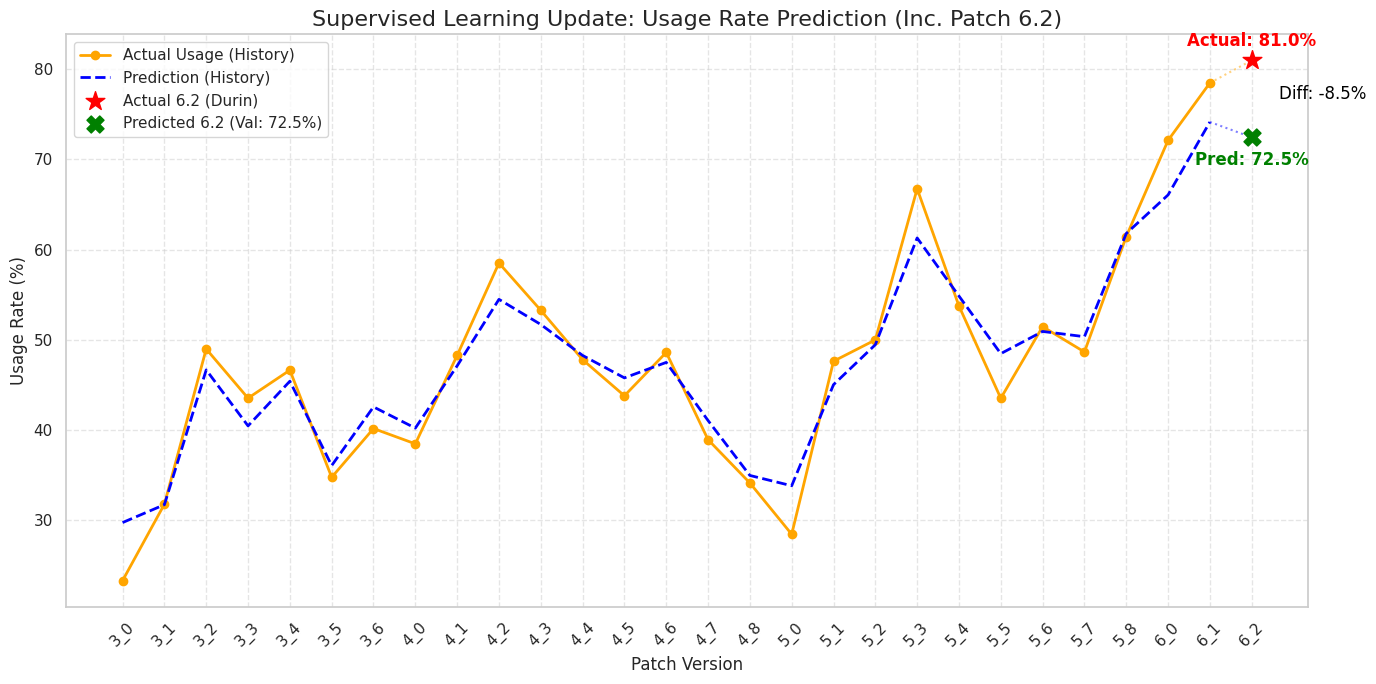

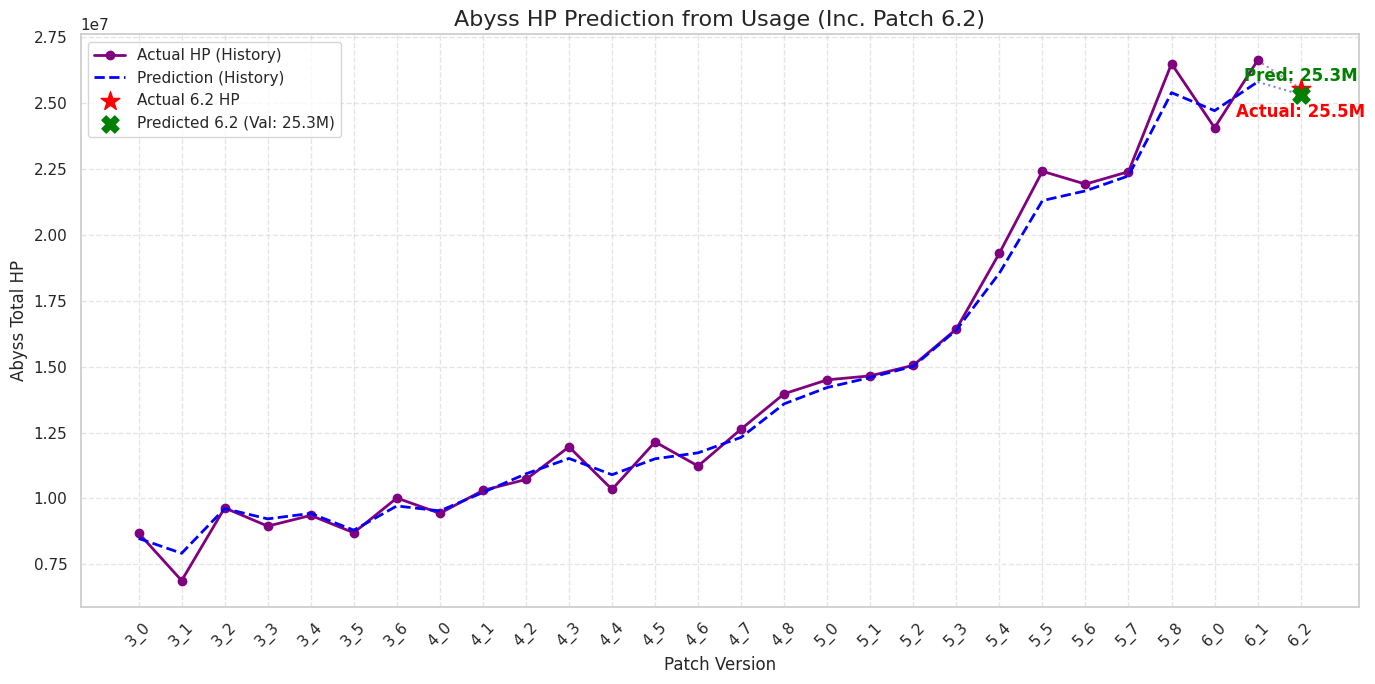

In [59]:
new_patch_label = '6_2'
new_hp_val = 25526574
new_usage_val = 81.0
new_time_index = merged_df['Time_Index'].max() + 1

pred_usage_62 = rf_usage.predict([[new_hp_val, new_time_index]])[0]
pred_hp_62 = rf_hp.predict([[new_usage_val, new_time_index]])[0]

plt.figure(figsize=(14, 7))

plt.plot(merged_df['patch'], merged_df['Generalized'], label='Actual Usage (History)', marker='o', color='orange', linewidth=2)
plt.plot(merged_df['patch'], merged_df['Predicted_Usage'], label='Prediction (History)', linestyle='--', color='blue', linewidth=2)

plt.scatter([new_patch_label], [new_usage_val], color='red', s=200, marker='*', label='Actual 6.2 (Durin)', zorder=5)
plt.scatter([new_patch_label], [pred_usage_62], color='green', s=150, marker='X', label=f'Predicted 6.2 (Val: {pred_usage_62:.1f}%)', zorder=5)

last_patch = merged_df['patch'].iloc[-1]
last_usage = merged_df['Generalized'].iloc[-1]
last_pred = merged_df['Predicted_Usage'].iloc[-1]

plt.plot([last_patch, new_patch_label], [last_usage, new_usage_val], color='orange', linestyle=':', alpha=0.5)
plt.plot([last_patch, new_patch_label], [last_pred, pred_usage_62], color='blue', linestyle=':', alpha=0.5)

plt.annotate(f'Actual: {new_usage_val}%', (new_patch_label, new_usage_val), xytext=(0, 10), textcoords='offset points', ha='center', fontweight='bold', color='red')
plt.annotate(f'Pred: {pred_usage_62:.1f}%', (new_patch_label, pred_usage_62), xytext=(0, -20), textcoords='offset points', ha='center', fontweight='bold', color='green')
plt.annotate(f'Diff: {pred_usage_62 - new_usage_val:.1f}%', (new_patch_label, (new_usage_val + pred_usage_62)/2), xytext=(20, 0), textcoords='offset points', color='black')

plt.title('Supervised Learning Update: Usage Rate Prediction (Inc. Patch 6.2)', fontsize=16)
plt.xlabel('Patch Version')
plt.ylabel('Usage Rate (%)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Updated_Usage_Prediction_Graph.png')

plt.figure(figsize=(14, 7))

plt.plot(merged_df['patch'], merged_df['Total'], label='Actual HP (History)', marker='o', color='purple', linewidth=2)
plt.plot(merged_df['patch'], merged_df['Predicted_HP'], label='Prediction (History)', linestyle='--', color='blue', linewidth=2)

plt.scatter([new_patch_label], [new_hp_val], color='red', s=200, marker='*', label='Actual 6.2 HP', zorder=5)
plt.scatter([new_patch_label], [pred_hp_62], color='green', s=150, marker='X', label=f'Predicted 6.2 (Val: {pred_hp_62/1e6:.1f}M)', zorder=5)

last_hp = merged_df['Total'].iloc[-1]
last_pred_hp = merged_df['Predicted_HP'].iloc[-1]
plt.plot([last_patch, new_patch_label], [last_hp, new_hp_val], color='purple', linestyle=':', alpha=0.5)
plt.plot([last_patch, new_patch_label], [last_pred_hp, pred_hp_62], color='blue', linestyle=':', alpha=0.5)

plt.annotate(f'Actual: {new_hp_val/1e6:.1f}M', (new_patch_label, new_hp_val), xytext=(0, -20), textcoords='offset points', ha='center', fontweight='bold', color='red')
plt.annotate(f'Pred: {pred_hp_62/1e6:.1f}M', (new_patch_label, pred_hp_62), xytext=(0, 10), textcoords='offset points', ha='center', fontweight='bold', color='green')

plt.title('Abyss HP Prediction from Usage (Inc. Patch 6.2)', fontsize=16)
plt.xlabel('Patch Version')
plt.ylabel('Abyss Total HP')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('Updated_HP_Prediction_Graph.png')

print("Graphs generated successfully.")